In [1]:
import sys 
sys.path.append("../")
from QAOAUtils import * 

In [2]:
from scipy.linalg import expm 
default_data_full = []
GW2_data_full = []
GW3_data_full = []
scores = []
n = 12
for i in tqdm(range(20)):
    A = rand_adj(n)
    
    Y = GW(A)  ###calculate the full GW embedding
    _,GW2_angles,_ = GW2(A,GW_Y=Y,reps=100) ###project to 2d angles using precalculated GW embedding 
    _,GW3_angles,_ = GW3(A,GW_Y=Y,reps=100) ###project to 2d angles using precalculated GW embedding 

    ###Get circuit information for each warmstart. Circuit information consists of the initial state + the mixer operators for each qubit
    GW2_circ_data = Q2_data(GW2_angles,rotation = 0)
    GW3_circ_data = Q3_data(GW3_angles,rotation = 0)

    precomp  = pre_compute(A) ###compute the Hamiltonian information for the cost layers (shared for all circuits)    
    
    default_data = np.zeros((100,100))
    for x,i in enumerate(np.linspace(0,2*np.pi,100)):
        for y,j in enumerate(np.linspace(0,2*np.pi,100)):
            default_data[x,y] = expval(precomp,QAOA_eval(precomp,[i,j],mixer_ops=None,init=None))
            
    GW2_data = np.zeros((100,100))
    for x,i in enumerate(np.linspace(0,2*np.pi,100)):
        for y,j in enumerate(np.linspace(0,2*np.pi,100)):
            GW2_data[x,y] = expval(precomp,QAOA_eval(precomp,[i,j],mixer_ops=GW2_circ_data[1],init=GW2_circ_data[0]))
            
    GW3_data = np.zeros((100,100))
    for x,i in enumerate(np.linspace(0,2*np.pi,100)):
        for y,j in enumerate(np.linspace(0,2*np.pi,100)):
            GW3_data[x,y] = expval(precomp,QAOA_eval(precomp,[i,j],mixer_ops=GW3_circ_data[1],init=GW3_circ_data[0]))
            
    default_grad_norm = np.sqrt(np.gradient(default_data)[0]**2 + np.gradient(default_data)[1]**2)
    GW2_grad_norm = np.sqrt(np.gradient(GW2_data)[0]**2 + np.gradient(GW2_data)[1]**2)
    GW3_grad_norm = np.sqrt(np.gradient(GW3_data)[0]**2 + np.gradient(GW3_data)[1]**2)
    
    
    default_data_full.append([(np.max(default_data) - np.min(precomp))/(np.max(precomp) - np.min(precomp)), np.var(default_grad_norm)] )
    GW2_data_full.append([(np.max(GW2_data) - np.min(precomp))/(np.max(precomp) - np.min(precomp)), np.var(GW2_grad_norm)] )
    GW3_data_full.append([(np.max(GW3_data) - np.min(precomp))/(np.max(precomp) - np.min(precomp)), np.var(GW3_grad_norm)] )
    
    default_max = find_local_extrema(default_data)[-1]
    default_A = nearest_max(default_data,default_max,100)
            
    GW2_max = find_local_extrema(GW2_data)[-1]
    GW2_A = nearest_max(GW2_data,GW2_max,100)
    
    GW3_max = find_local_extrema(GW3_data)[-1]
    GW3_A = nearest_max(GW3_data,GW3_max,100)
            
    scores.append([np.mean(default_A),np.mean(GW2_A),np.mean(GW3_A)])


  0%|          | 0/20 [00:00<?, ?it/s]

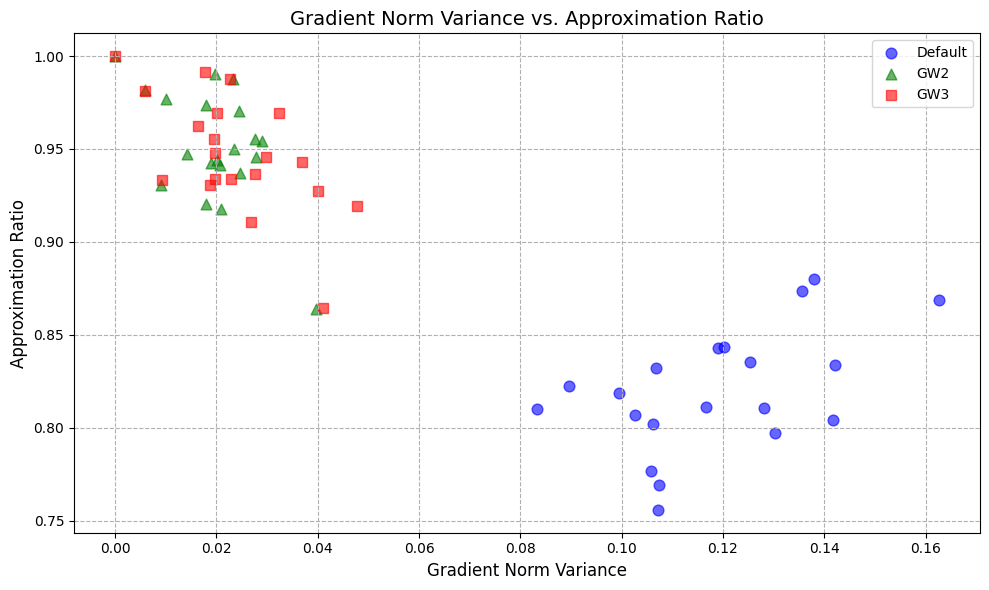

In [3]:
# Convert to arrays and transpose for plotting
default_data = np.array(default_data_full).T[::-1]
gw2_data = np.array(GW2_data_full).T[::-1]
gw3_data = np.array(GW3_data_full).T[::-1]

plt.figure(figsize=(10, 6))  # Set figure size

# Plot each dataset with reduced opacity
plt.scatter(*default_data, label='Default', color='blue', marker='o', s=60, alpha=0.6)
plt.scatter(*gw2_data, label='GW2', color='green', marker='^', s=60, alpha=0.6)
plt.scatter(*gw3_data, label='GW3', color='red', marker='s', s=60, alpha=0.6)

# Label axes and add a title
plt.xlabel('Gradient Norm Variance', fontsize=12)
plt.ylabel('Approximation Ratio', fontsize=12)
plt.title('Gradient Norm Variance vs. Approximation Ratio', fontsize=14)

# Add legend
plt.legend()

plt.grid(True,linestyle='--')

plt.tight_layout()
plt.show()

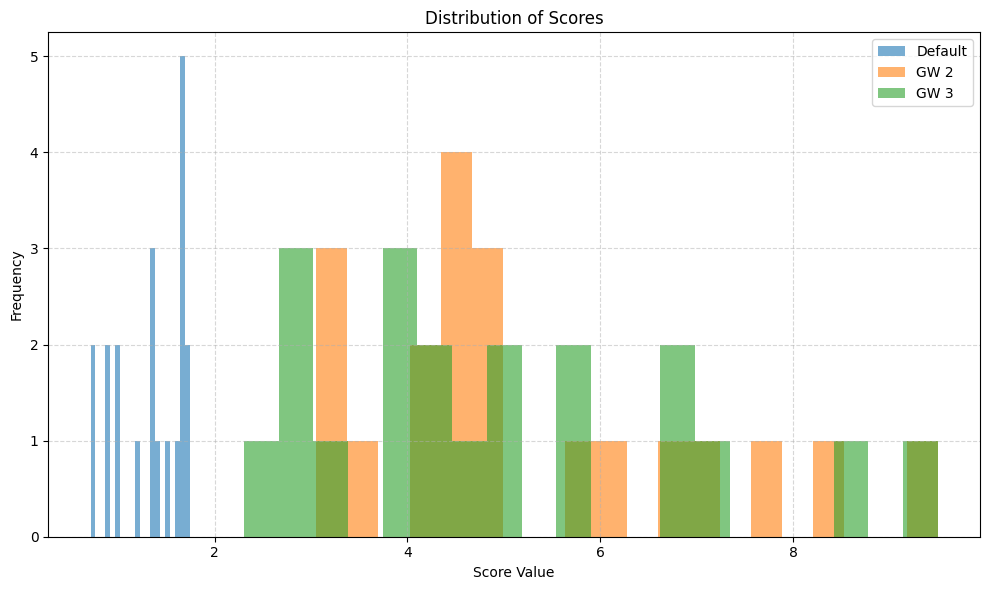

In [4]:

# Extract the individual score groups
score1 = [s[0] for s in scores]
score2 = [s[1] for s in scores]
score3 = [s[2] for s in scores]

# Plot with style
plt.figure(figsize=(10, 6))
bins = 20  # Adjust depending on your data range

plt.hist(score1, bins=bins, alpha=0.6, label='Default')
plt.hist(score2, bins=bins, alpha=0.6, label='GW 2')
plt.hist(score3, bins=bins, alpha=0.6, label='GW 3')

# Style enhancements
plt.title('Distribution of Scores')
plt.xlabel('Score Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()